# Analysis Helper Functions

Statistical analysis, visualization, and data enrichment functions.

## Setup

In [1]:
from pymaude import MaudeDatabase
import pandas as pd
import matplotlib.pyplot as plt

# Use shared database
# db = MaudeDatabase('notebooks.db', verbose=True)
# db.add_years('2020-2023', tables=['device', 'patient', 'text'], download=True, interactive=False)

db = MaudeDatabase('../analysis/venous_thrombectomy/maude_2008_2025.db', verbose=True)


db.create_search_index()

print("Setup complete!")

Search index already exists and is up to date
Setup complete!


## Trend Analysis

Calculate year-by-year event counts:

   year  event_count
0  2020        51408
1  2021        53260
2  2022        58272
3  2023        71103


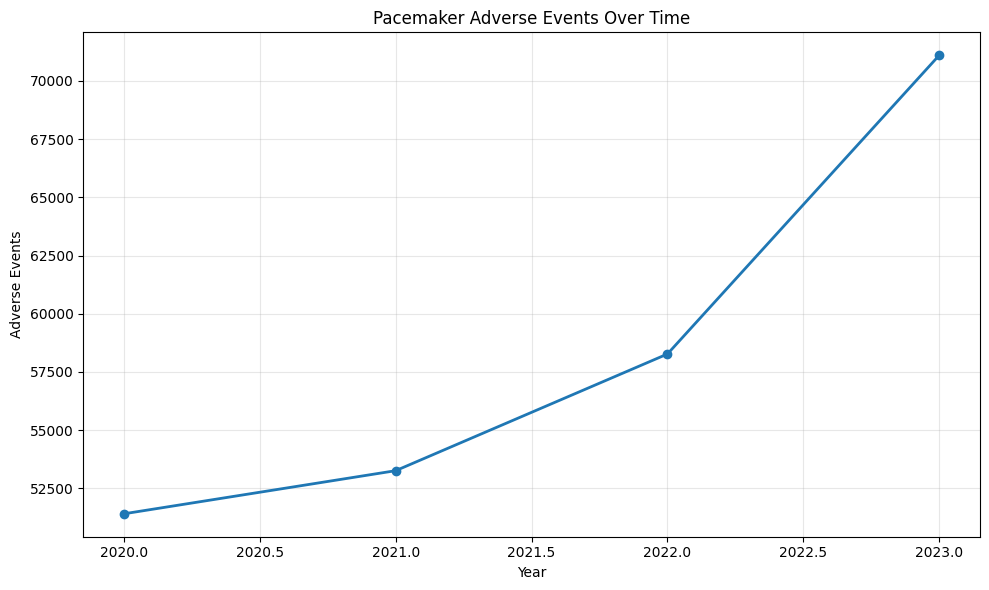

In [2]:
# Get device events
results = db.search_by_device_names('pacemaker', start_date='2020-01-01', end_date='2023-12-31')

# Calculate trends
trends = db.get_trends_by_year(results)
print(trends)

# Visualize
plt.figure(figsize=(10, 6))
plt.plot(trends['year'], trends['event_count'], marker='o', linewidth=2)
plt.xlabel('Year')
plt.ylabel('Adverse Events')
plt.title('Pacemaker Adverse Events Over Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Trends with Grouped Search

/Users/jakeumms/University of Michigan Dropbox/Jacob Schwartz/eras reserach projects/PyMAUDE/src/pymaude/database.py:1939: UserWarning: 13811 events previously matched to other groups were skipped from 'defibrillator'
  warnings.warn(


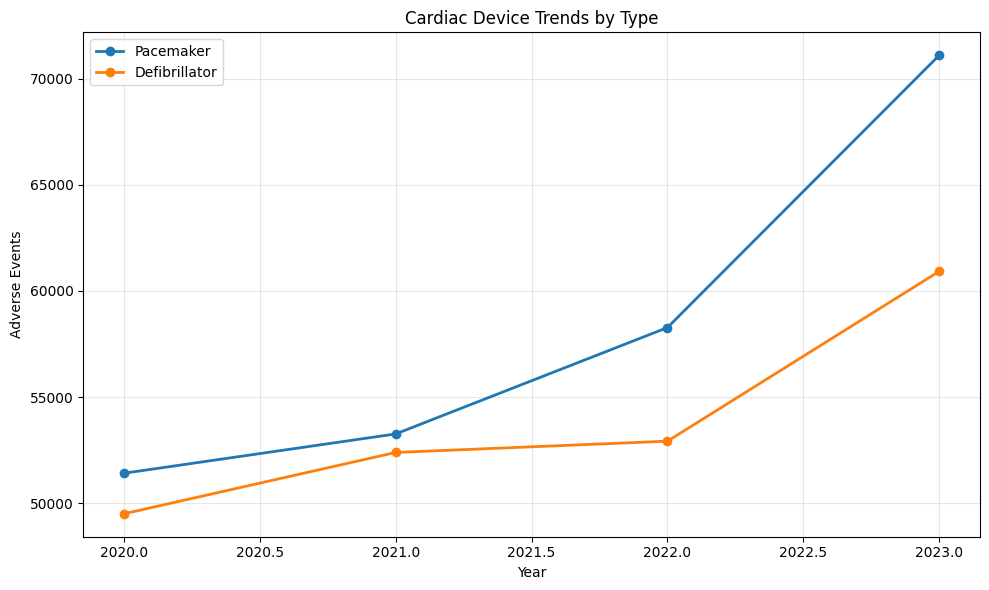

In [3]:
# Compare multiple device types
results = db.search_by_device_names({
    'pacemaker': 'pacemaker',
    'defibrillator': 'defibrillator'
}, start_date='2020-01-01', end_date='2023-12-31')

trends = db.get_trends_by_year(results)

# Plot grouped trends
plt.figure(figsize=(10, 6))
for group in results['search_group'].unique():
    group_trends = trends[trends['search_group'] == group]
    plt.plot(group_trends['year'], group_trends['event_count'], 
             marker='o', label=group.title(), linewidth=2)

plt.xlabel('Year')
plt.ylabel('Adverse Events')
plt.title('Cardiac Device Trends by Type')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary Statistics

Comprehensive statistics grouped by search_group or custom column:

In [4]:
# Grouped search automatically uses search_group
results = db.search_by_device_names({
    'pacemaker': 'pacemaker',
    'defibrillator': 'defibrillator',
    'icd': ['icd', 'implantable cardioverter']
}, start_date='2020-01-01', end_date='2023-12-31')

summary = db.summarize_by_brand(results)

print("Event counts by device type:")
print(summary['counts'])

print("\nEvent types by device:")
print(summary['event_types'])

/Users/jakeumms/University of Michigan Dropbox/Jacob Schwartz/eras reserach projects/PyMAUDE/src/pymaude/database.py:1939: UserWarning: 13811 events previously matched to other groups were skipped from 'defibrillator'
  warnings.warn(
/Users/jakeumms/University of Michigan Dropbox/Jacob Schwartz/eras reserach projects/PyMAUDE/src/pymaude/database.py:1939: UserWarning: 114394 events previously matched to other groups were skipped from 'icd'
  warnings.warn(


Event counts by device type:
{'pacemaker': 234043, 'defibrillator': 215727, 'icd': 17338}

Event types by device:
EVENT_TYPE     *     D      IN       M   O
search_group                              
defibrillator  0  3271   83743  128686  17
icd            0    73    6968   10297   0
pacemaker      1  3166  111068  119779  24


## Event Type Comparison

Compare event type distributions with statistical testing:

In [5]:
results = db.search_by_device_names({
    'insulin_pump': 'insulin pump',
    'glucose_monitor': 'glucose monitor'
}, start_date='2020-01-01', end_date='2023-12-31')

comparison = db.event_type_comparison(results)

print("Event type comparison:")
print(comparison['summary'])

chi_sq = comparison['chi2_test']
print(f"\nChi-square: {chi_sq['chi2_statistic']:.2f}")
print(f"P-value: {chi_sq['p_value']:.4f}")

if chi_sq['p_value'] < 0.05:
    print("\n✓ Statistically significant difference")
else:
    print("\n✗ No significant difference")

/Users/jakeumms/University of Michigan Dropbox/Jacob Schwartz/eras reserach projects/PyMAUDE/src/pymaude/database.py:1939: UserWarning: 24 events previously matched to other groups were skipped from 'glucose_monitor'
  warnings.warn(


Event type comparison:
Event Type Comparison by search_group
Chi-square: 22453.08 (p=0.0000)

glucose_monitor: 0.0% deaths, 4.1% injuries, 95.9% malfunctions
insulin_pump: 0.1% deaths, 9.0% injuries, 90.9% malfunctions

Chi-square: 22453.08
P-value: 0.0000

✓ Statistically significant difference


## Patient Data Enrichment

Add patient outcome information:

In [6]:
results = db.search_by_device_names('defibrillator')
print(f"Device events: {len(results)}")

# Enrich with patient data
enriched = db.enrich_with_patient_data(results)
print(f"Events with patient data: {len(enriched)}")

# Count unique outcomes
outcome_summary = db.count_unique_outcomes_per_report(enriched)

# Count reports with death
deaths = outcome_summary['unique_outcomes'].apply(lambda x: 'D' in x).sum()
print(f"\nReports with death: {deaths} ({100*deaths/len(outcome_summary):.1f}%)")

# Count hospitalizations
hosp = outcome_summary['unique_outcomes'].apply(lambda x: 'H' in x).sum()
print(f"Reports with hospitalization: {hosp} ({100*hosp/len(outcome_summary):.1f}%)")

Device events: 742761
Joined 741016 patient records
Events with patient data: 742804

Reports with death: 13903 (1.9%)
Reports with hospitalization: 151430 (20.4%)


## Narrative Enrichment

Add event narrative text:

In [7]:
results = db.search_by_device_names('catheter')

# Sample a few for narratives
sample = results.head(5)
narratives = db.get_narratives(sample['MDR_REPORT_KEY'].tolist())

if len(narratives) > 0:
    print("Sample narrative:")
    print(f"Report {narratives.iloc[0]['MDR_REPORT_KEY']}:")
    print(narratives.iloc[0]['FOI_TEXT'][:300], "...")

Sample narrative:
Report 973054:
THE PATIENT IS A MALE WHO PRESENTED TO THE HOSPITAL IN 2007 WITH ACUTE MI AND POOR LV FUNCTION. DUE TO POOR PROGNOSIS, THE PATIENT WAS NOT CANDIDATE FOR BYPASS SURGERY. THEREFORE, EMERGENCY PCI WAS ATTEMPTED. IN CATH-LAB AN IABP WAS PLACED AND ANGIOGRAPHY REVEALED A THROMBOTIC OCCLUSION IN THE CIRCU ...


## Brand Name Standardization

Standardize brand name variations for cleaner analysis:

In [8]:
results = db.search_by_device_names('insulin pump')

print("Original brand variations (sample):")
print(results['BRAND_NAME'].value_counts().head(5))

# Define mapping
mapping = {
    'T:SLIM X2 INSULIN PUMP WITH CONTROL-IQ TECHNOLOGY': 'Tandem t:slim X2',
    'T:SLIM X2 INSULIN PUMP WITH BASAL-IQ TECHNOLOGY': 'Tandem t:slim X2',
    'T:SLIM X2 WITH BASAL-IQ TECHNOLOGY': 'Tandem t:slim X2',
    '670G INSULIN PUMP MMT-1780KL': 'Medtronic 670G',
    '640G INSULIN PUMP MMT-1712K': 'Medtronic 640G'
}

standardized = db.standardize_brand_names(results, mapping)

print("\nStandardized brands:")
print(standardized['standard_brand'].value_counts().head(5))

Original brand variations (sample):
BRAND_NAME
T:SLIM X2 INSULIN PUMP WITH CONTROL-IQ TECHNOLOGY                                   503848
T:SLIM X2 INSULIN PUMP WITH INTEROPERABLE TECHNOLOGY (WITH T:CONNECT MOBILE APP)    261010
T:SLIM X2 INSULIN PUMP WITH BASAL-IQ TECHNOLOGY                                     141629
640G INSULIN PUMP MMT-1712K                                                         118634
630G INSULIN PUMP MMT-1715K 630G BLACK MG                                            85668
Name: count, dtype: int64

Standardized brands:
standard_brand
Tandem t:slim X2                                                                    645823
T:SLIM X2 INSULIN PUMP WITH INTEROPERABLE TECHNOLOGY (WITH T:CONNECT MOBILE APP)    261010
Medtronic 640G                                                                      118638
630G INSULIN PUMP MMT-1715K 630G BLACK MG                                            85668
Medtronic 670G                                                         

## Event Key Deduplication

Handle duplicate reports (same event, multiple sources):

In [9]:
results = db.search_by_device_names('insulin pump')

# Check duplication
dup_stats = db.count_unique_events(results)

print("Duplication analysis:")
print(f"Total reports: {dup_stats['total_reports']}")
print(f"Unique events: {dup_stats['unique_events']}")
print(f"Duplication rate: {dup_stats['duplication_rate']:.1f}%")

if dup_stats['duplication_rate'] > 5:
    # Deduplicate by keeping first received
    deduped = db.select_primary_report(results, strategy='first_received')
    print(f"\nDeduplicated to {len(deduped)} unique events")

Duplication analysis:
Total reports: 1850096
Unique events: 1850096
Duplication rate: 0.0%


## Combined Workflow Example

Typical analysis combining multiple helpers:

In [10]:
# Step 1: Grouped search
results = db.search_by_device_names({
    'pacemaker': 'pacemaker',
    'defibrillator': 'defibrillator'
}, start_date='2020-01-01', end_date='2023-12-31')

print(f"Total events: {len(results)}")

# Step 2: Check deduplication
dup_stats = db.count_unique_events(results)
print(f"Duplication rate: {dup_stats['duplication_rate']:.1f}%")

if dup_stats['duplication_rate'] > 5:
    results = db.select_primary_report(results, strategy='first_received')
    print(f"Deduplicated to {len(results)} events")

# Step 3: Summary statistics
summary = db.summarize_by_brand(results)
print("\nEvent counts:")
print(summary['counts'])

# Step 4: Event type comparison
comparison = db.event_type_comparison(results)
if comparison['chi2_test']['p_value'] < 0.05:
    print("\n✓ Significant difference in event types")

# Step 5: Patient outcomes
enriched = db.enrich_with_patient_data(results)
outcome_summary = db.count_unique_outcomes_per_report(enriched)
deaths = outcome_summary['unique_outcomes'].apply(lambda x: 'D' in x).sum()
print(f"\nReports with death: {deaths} ({100*deaths/len(outcome_summary):.1f}%)")

# Step 6: Export
results.to_csv('cardiac_device_analysis.csv', index=False)
print("\nResults exported to cardiac_device_analysis.csv")

/Users/jakeumms/University of Michigan Dropbox/Jacob Schwartz/eras reserach projects/PyMAUDE/src/pymaude/database.py:1939: UserWarning: 13811 events previously matched to other groups were skipped from 'defibrillator'
  warnings.warn(


Total events: 449770
Duplication rate: 0.0%

Event counts:
{'pacemaker': 234043, 'defibrillator': 215727}

✓ Significant difference in event types
Joined 448688 patient records

Reports with death: 6479 (1.4%)

Results exported to cardiac_device_analysis.csv


## Cleanup

In [11]:
db.close()

## Summary

### Analysis Functions
- `get_trends_by_year(df)` - Year-by-year event counts
- `summarize_by_brand(df)` - Comprehensive statistics
- `event_type_comparison(df)` - Statistical comparison
- `chi2_test(df, row, col)` - Custom statistical test

### Data Enrichment
- `enrich_with_patient_data(df)` - Add patient outcomes
- `enrich_with_narratives(df)` - Add event descriptions
- `enrich_with_problems(df)` - Add device problem codes

### Data Quality
- `count_unique_events(df)` - Check duplication
- `select_primary_report(df, strategy)` - Deduplicate
- `standardize_brand_names(df, mapping)` - Clean brand names

**Next**: [05_advanced_workflows.ipynb](05_advanced_workflows.ipynb) - Complete research workflows